In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from mingpt.utils import set_seed
set_seed(3407)
import random

## Dataset

In [2]:
def l_z(length, num):
    num_str = str(num)
    if len(num_str) < length:
        return '0'*(length-len(num_str)) + num_str
    return num_str

def step_mul(length):
    a = [random.randint(0,9) for i in range(length)]
    b = [random.randint(0,9) for i in range(length)]

    val_a = int(''.join(str(d) for d in a))
    val_b = int(''.join(str(d) for d in b))
    if val_a < val_b:
        val_a, val_b = val_b, val_a
        a, b = b, a
    
    steps = [f"{l_z(length, val_b)}*{l_z(length, val_a)}="]
    steps_eq = []
    for i in range(length):
        a_i = a[i] * 10**(length-i-1)
        # a_i = str(a[i]) 
        steps.append(f"{l_z(length, val_b)}*{l_z(length, a_i)}+")
        steps_eq.append(l_z(2*length, a_i*val_b)+"+")
    
    steps[-1] = steps[-1][:-1] + "="
    steps_eq[-1] = steps_eq[-1][:-1] + "="

    steps.extend(steps_eq)
    steps.append(l_z(2*length, val_a*val_b))
    out = ''.join(steps)
    # out = list(out)
    return out
    # print(out)

def tokenize_string(string):
    out = []
    for char in string:
        if char == '+':
            out.append(10)
        elif char == '=':
            out.append(11)
        elif char == '*':
            out.append(12)
        else:
            out.append(int(char))
    return out


eq = step_mul(3)
print(eq)
tokenize_string(eq)


062*536=062*500+062*030+062*006=031000+001860+000372=033232


[0,
 6,
 2,
 12,
 5,
 3,
 6,
 11,
 0,
 6,
 2,
 12,
 5,
 0,
 0,
 10,
 0,
 6,
 2,
 12,
 0,
 3,
 0,
 10,
 0,
 6,
 2,
 12,
 0,
 0,
 6,
 11,
 0,
 3,
 1,
 0,
 0,
 0,
 10,
 0,
 0,
 1,
 8,
 6,
 0,
 10,
 0,
 0,
 0,
 3,
 7,
 2,
 11,
 0,
 3,
 3,
 2,
 3,
 2]

In [3]:
class MulDataset(Dataset):
    """ 
    Dataset for the Add problem. E.g. for problem length 3:
    12 + 333 = 345
    Input: 0 1 2 3 3 3 -> Output: 0 3 4 5
    Which will feed into the transformer concatenated as:
    input:  0 1 2 3 3 3 0 3 4
    output: I I I I I 0 3 4 5
    where I is "ignore", as the transformer is reading the input sequence
    """

    def __init__(self, split, length=3):
        assert split in {'train', 'test'}
        self.split = split
        self.length = length
    
    def __len__(self):
        return 1000 # ...
    
    def get_vocab_size(self):
        return 13
    
    def get_block_size(self):
        # the length of the sequence that will feed into transformer, 
        # containing concatenated input and the output, but -1 because
        # the transformer starts making predictions at the last input element
        return len(tokenize_string(step_mul(self.length))) - 1

    def __getitem__(self, idx):
        while True:
            rai = tokenize_string(step_mul(self.length))
            h = hash(str(rai[:1+2*self.length]))
            
            inp_split = 'test' if h % 4 == 0 else 'train' # designate 25% of examples as test
            if inp_split == self.split:
                break # ok
        
        x = torch.tensor(rai[:-1], dtype=torch.long)
        y = torch.tensor(rai[1:], dtype=torch.long)
        
        # we only want to predict at output locations, mask out the loss at the input locations
        y[:2*self.length] = -1
        return x, y

In [4]:
# print an example instance of the dataset
train_dataset = MulDataset('train')
test_dataset = MulDataset('test')
x, y = train_dataset[0]

print (x)
for a, b in zip(x,y):
    print(int(a),int(b))

tensor([ 3,  7,  8, 12,  4,  9,  5, 11,  3,  7,  8, 12,  4,  0,  0, 10,  3,  7,
         8, 12,  0,  9,  0, 10,  3,  7,  8, 12,  0,  0,  5, 11,  1,  5,  1,  2,
         0,  0, 10,  0,  3,  4,  0,  2,  0, 10,  0,  0,  1,  8,  9,  0, 11,  1,
         8,  7,  1,  1])
3 -1
7 -1
8 -1
12 -1
4 -1
9 -1
5 11
11 3
3 7
7 8
8 12
12 4
4 0
0 0
0 10
10 3
3 7
7 8
8 12
12 0
0 9
9 0
0 10
10 3
3 7
7 8
8 12
12 0
0 0
0 5
5 11
11 1
1 5
5 1
1 2
2 0
0 0
0 10
10 0
0 3
3 4
4 0
0 2
2 0
0 10
10 0
0 0
0 1
1 8
8 9
9 0
0 11
11 1
1 8
8 7
7 1
1 1
1 0


## Model

In [5]:
from mingpt.model import GPT

model_config = GPT.get_default_config()
model_config.model_type = 'gpt-micro'
# model_config.model_type = 'gpt-nano'

model_config.vocab_size = train_dataset.get_vocab_size()
model_config.block_size = train_dataset.get_block_size()
model = GPT(model_config)

number of parameters: 0.80M


In [10]:
# model.load_state_dict(torch.load('model_step_85.pth'))

model.load_state_dict(torch.load('model_step_85.pth', map_location='cpu'))

/tmp/ipykernel_242553/2938202400.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_step_85.pth', map_location='cpu'))


<All keys matched successfully>

In [7]:
print (model_config.n_head, model_config.n_layer, model_config.n_embd)

4 4 128


In [8]:
# create a Trainer object
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 1e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 5000
train_config.num_workers = 0
# train_config.batch_size = 32
trainer = Trainer(train_config, model, train_dataset)

running on device cpu


In [9]:
def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

iter_dt 0.00ms; iter 0: train loss 0.01482


KeyboardInterrupt: 

In [12]:
# now let's perform some evaluation
model.eval()
None

evaluating train batch 1/8
evaluating train batch 2/8
evaluating train batch 3/8
evaluating train batch 4/8
evaluating train batch 5/8
evaluating train batch 6/8
evaluating train batch 7/8
evaluating train batch 8/8
train final score: 343/400 = 85.75% correct
evaluating test batch 1/8
evaluating test batch 2/8
evaluating test batch 3/8
evaluating test batch 4/8
evaluating test batch 5/8
evaluating test batch 6/8
evaluating test batch 7/8
evaluating test batch 8/8
test final score: 333/400 = 83.25% correct


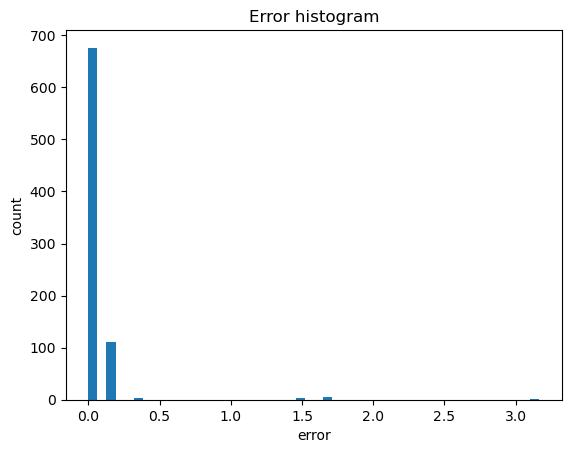

In [24]:
import matplotlib.pyplot as plt

errors = []

def eval_add_split(trainer, split, max_batches):
    dataset = {'train':train_dataset, 'test':test_dataset}[split]
    n = train_dataset.length # naugy direct access shrug
    results = []
    mistakes_printed_already = 0
    loader = DataLoader(dataset, batch_size=50, num_workers=0, drop_last=False)
    #loader = DataLoader(dataset, batch_size=1, num_workers=0, drop_last=False)
    for b, (x, y) in enumerate(loader):
        print(f"evaluating {split} batch {b+1}/{min(len(loader), max_batches)}")

        x = x.to(trainer.device)
        y = y.to(trainer.device)

        inp = x[:, :2*n+1]
        sol = y[:, -2*n:]
        
        cat = model.generate(inp, 52, do_sample=False) # using greedy argmax, not sampling
        sol_candidate = cat[:, -2*n:]      
        # print(cat[0])
        # print(inp[0])
        # print(sol[0])   
        # print(sol_candidate[0])
        correct = (sol == sol_candidate).all(1).cpu() 
        incorrect = ~correct
        mae = (sol - sol_candidate).abs().float().mean(1).cpu()
        errors.extend(mae.tolist())

        for i in range(x.size(0)):
            results.append(int(correct[i]))
    
        if b+1 >= max_batches:
            break

    rt = torch.tensor(results, dtype=torch.float)
    print("%s final score: %d/%d = %.2f%% correct" % (split, rt.sum(), len(results), 100*rt.mean()))
    return rt.sum()

# run a lot of examples from both train and test through the model and verify the output correctness
with torch.no_grad():
    train_score = eval_add_split(trainer, 'train', max_batches=8)
    test_score  = eval_add_split(trainer, 'test',  max_batches=8)

plt.hist(errors, bins=50)
plt.xlabel('error')
plt.ylabel('count')
plt.title('Error histogram')
plt.show()

In [14]:
torch.save(model.state_dict(), 'model_step_85.pth')